In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings

In [2]:
# Set the system parameters
a = 2.46
uD = 1
t0 = 3.1
t1 = 5
t2 = -0.21
t3 = 0.29
t4 = 0.141
Nl = 1

1

The above parameters are the ones to be used when computing the energies of the Hamiltonian. 
- $a$ is the lattice constant.
- $u_D$ is the potential difference per layer
- $t_0$ is the graphene hopping
- $t_1$ is the vertical interlayer hopping
- $t_2, t_3, t_4$ are higher order (next-nearest, next-next-nearest, ...) hopping
- $N_l$ is the number of layers

<font size="12">RMG Hamiltonian</font>

In this section we will be constructing the RMG Hamiltonian, which is given by the following form:

\begin{equation*}
h_{RG}^{(N_l)} (k) = 
    \begin{bmatrix}
    h_1^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(1)}}^\dagger & h_2^{(0)} & h^{(1)} & h^{(2)} \\
    {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_3^{(0)} & \ddots & \ddots \\
    & {h^{(2)}}^\dagger & \ddots & \ddots & h^{(1)} & h^{(2)} \\
    & & \ddots & {h^{(1)}}^\dagger & h_{N_l - 1}^{(0)} & h^{(1)} \\
    & & & {h^{(2)}}^\dagger & {h^{(1)}}^\dagger & h_{N_l}^{(0)}
    \end{bmatrix}
\end{equation*}
where 

\begin{equation*}
h_l^{(0)} (k) = 
    \begin{bmatrix}
    u_{Al} & -t_0 f_k \\
    -t_0 \bar{f_k} & u_{B l}
    \end{bmatrix}
\end{equation*}
and 

\begin{equation*}
h^{(1)} (k) = 
    \begin{bmatrix}
    t_4 f_k & t_3 \bar{f_k} \\
    t_1 & t_4 f_k
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
h^{(2)} (k) = 
    \begin{bmatrix}
    0 & \frac{t_2}{2} \\
    0 & 0
    \end{bmatrix}
\end{equation*}
and

\begin{equation*}
f_k = \sum_{i = 0}^2 e^{i \vec{k} \cdot \vec{\delta}_i}
\end{equation*}

- The nearest-neighbor vectors $\vec{\delta}_n$ take the form 
$\vec{\delta}_n = R_{n 2 \pi / 3} (0, \frac{1}{\sqrt{3}} a)^T$ where $R_\theta$ is the counterclockwise rotation matrix by angle $\theta$.
- $u_{\sigma, l} = u_D (l + 1 - \frac{N_l - 1}{2})$

In [3]:
# 2D CCW rotation of v by theta
function rot(theta, v)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R * v
end

rot (generic function with 1 method)

In [4]:
function f(k, a)
    kx = k[1]
    ky = k[2]
    return exp(1im * ky * a / sqrt(3)) * (1 + 2 * exp(-1im * 3 * ky * a / (2 * sqrt(3))) * cos(kx * a / 2))
end

f (generic function with 1 method)

The above functions simply serve to calculate the in-layer graphene hopping contributions.

In [5]:
function uAB(uD, Nl, l)
    return uD * (l + 1 - (1/2) * (Nl - 1))
end

uAB (generic function with 1 method)

Above is the on-site potential as a function of layer-index ($l$). 

In [6]:
function h0(uD, Nl, l, t0, a, k)
    uA = uAB(uD, Nl, l)
    uB = uAB(uD, Nl, l)
    h0 = zeros(ComplexF64, 2, 2)
    h0[1, 1] = uA
    h0[2, 2] = uB
    h0[1, 2] = -t0 * f(k, a)
    h0[2, 1] = -t0 * conj(f(k, a))
    return h0
end

h0 (generic function with 1 method)

The above function calculates the matrix $h_0$ in sublattice space.

In [7]:
function h1(t1, t3, t4, a, k)
    h1 = zeros(ComplexF64, 2, 2)
    h1[1, 1] = t4 * f(k, a)
    h1[1, 2] = t3 * conj(f(k, a))
    h1[2, 1] = t1
    h1[2, 2] = t4 * f(k, a)
    return h1
end

h1 (generic function with 1 method)

The above function calculates the matrix $h_1$ in sublattice space.

In [8]:
function h2(t2)
    h2 = zeros(ComplexF64, 2, 2)
    h2[1,2] = t2/2
    return h2
end

h2 (generic function with 1 method)

The above function calculates the matrix $h_2$ in sublattice space.

In [9]:
function hRG(a, uD, t0, t1, t2, t3, t4, Nl, k)
    # calculate the portion of hRG that has h0 on the diagonal
    ham0 = zeros(2 * Nl, 2 * Nl)
    for l in 1:Nl
        temp = zeros(Nl, Nl)
        temp[l, l] = 1
        ham0 += kron(h0(uD, Nl, l, t0, a, k), temp)
    end
    # calculate the portion of hRG that has h1 1 above and below the diagonal
    utri1 = zeros(Nl, Nl)
    for i in 2:Nl
        utri1[i - 1, i] = 1
    end
    ham1 = kron(h1(t1, t3, t4, a, k), utri1) + adjoint(kron(h1(t1, t3, t4, a, k), utri1))
    # calculate the portion of hRG that h2 2 above and below the diagonal
    utri2 = zeros(Nl, Nl)
    for i in 3:Nl
        utri2[i - 2, i] = 1
    end
    ham2 = kron(h2(t2), utri2) + adjoint(kron(h2(t2), utri2))
    # get all the contributions of hRG from the various matrices in sublattice space
    return ham0 + ham1 + ham2
end

hRG (generic function with 1 method)

To test out the hRG Hamiltonian-constructing function, we plot the band-structure of monolayer graphene.

<font size="12">Monolayer Graphene Band Structure</font>

In [10]:
samps = 1000
k_range = range(-2*pi/a, 2*pi/a, samps)

-2.5541403687721895:0.005113394131676055:2.5541403687721895

In [11]:
# Get the dipersions for fixed ky
K_temp_vals = Array{Float64}(undef, samps, samps, 2 * Nl)
K_temp_points = Array{Float64}(undef, samps, samps, 2)
for i in 1:samps
    for j in 1:samps
        kx = k_range[i]
        ky = k_range[j]
        ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
        vals = eigvals(ham)
        K_temp_vals[i, j, :] = real(vals)
        K_temp_points[i, j, :] = [kx, ky]
    end
end

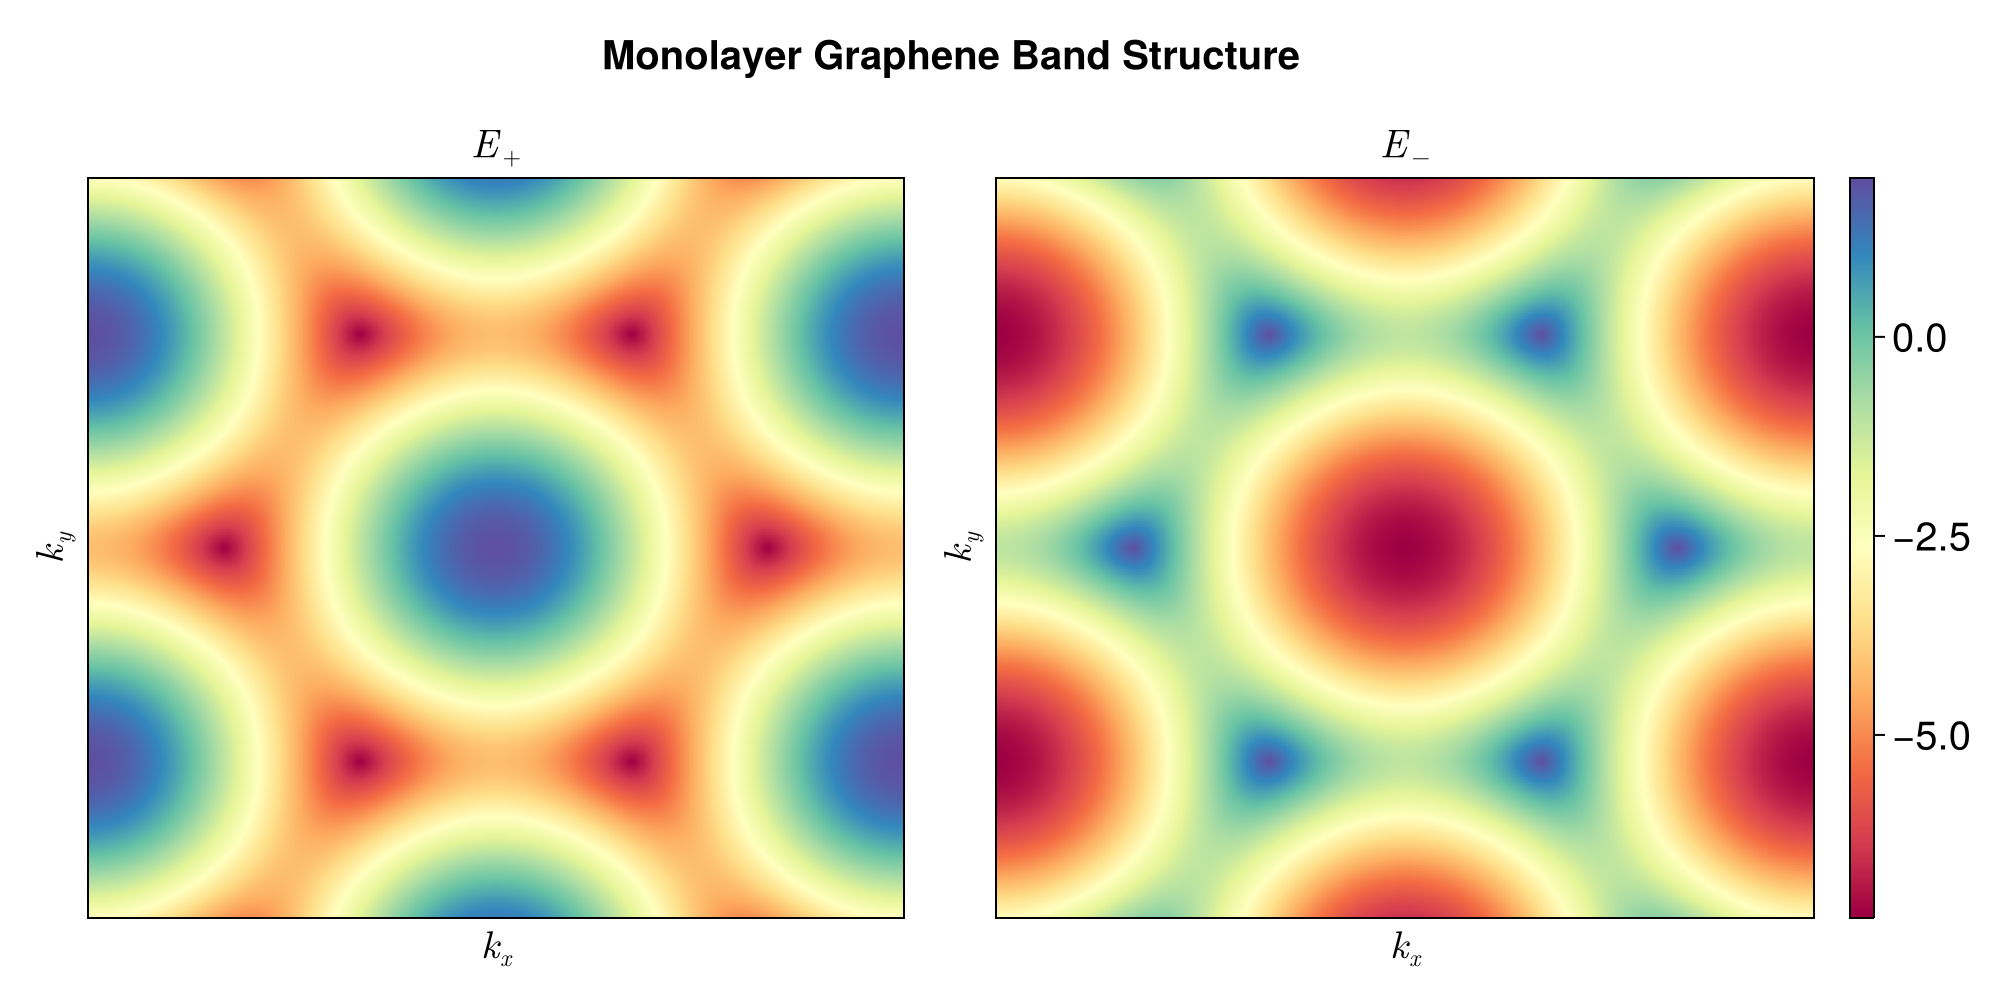

In [12]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)

# create and configure axes
ax_plus = Axis(P[1, 1], title = L"E_+", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_plus, label = false)
ax_minus = Axis(P[1, 2], title = L"E_-", xlabel = L"k_x", ylabel = L"k_y")
hidedecorations!(ax_minus, label = false)
ax_major = Axis(P[:, :], title = "Monolayer Graphene Band Structure", titlegap = 50)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

#plot dispersions
heatmap!(ax_plus, k_range, k_range, K_temp_vals[:, :, 2], colormap = :Spectral)
heatmap!(ax_minus, k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)
X, ax, tr = heatmap(k_range, k_range, K_temp_vals[:, :, 1], colormap = :Spectral)

#create and configure the colorbar
cb = Colorbar(P[1, 3], tr)
P

Evidently the Hamiltonian creation and diagonalization appears to be working (at least for $N_l = 1$), so we will proceed with the analysis of RMG

<font size="12">RMG Band Structure</font>

In [13]:
# Increase layer number
Nl = 3
# These vectors will be useful for computing energies at high-symmetry (K and K') points
G1 = [2*pi/a; -2*pi/(sqrt(3) * a)]
G2 = [0; 2*pi/a * 2/sqrt(3)]
K = (2/3) * G1 + (1/3) * G2
Kp = (1/3) * G1 + (2/3) * G2

2-element Vector{Float64}:
 0.8513801229240632
 1.4746336294587135

- $G_1 = \frac{2 \pi}{a} \left(1, - \frac{1}{\sqrt{3}}\right)$ and $G_2 = \frac{2 \pi}{a} \left(0, \frac{2}{\sqrt{3}}\right)$ are reciprocal lattice basis vectors
- $K = \frac{2}{3} G_1 + \frac{1}{3} G_2$ and $K^\prime = \frac{1}{3} G_1 + \frac{2}{3} G_2$ are Dirac points

In [14]:
# Want to get dispersions around K point
K_eigenvals = Array{Float64}(undef, samps, 2 * Nl)
for i in 1:samps
    kx = k_range[i]
    ky = K[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    K_eigenvals[i, :] = real(vals)
end
# Want to get dispersions around K' point
Kp_eigenvals = Array{Float64}(undef, samps, 2 * Nl)

for i in 1:samps
    kx = k_range[i]
    ky = Kp[2]
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vals = eigvals(ham)
    Kp_eigenvals[i, :] = real(vals)
end

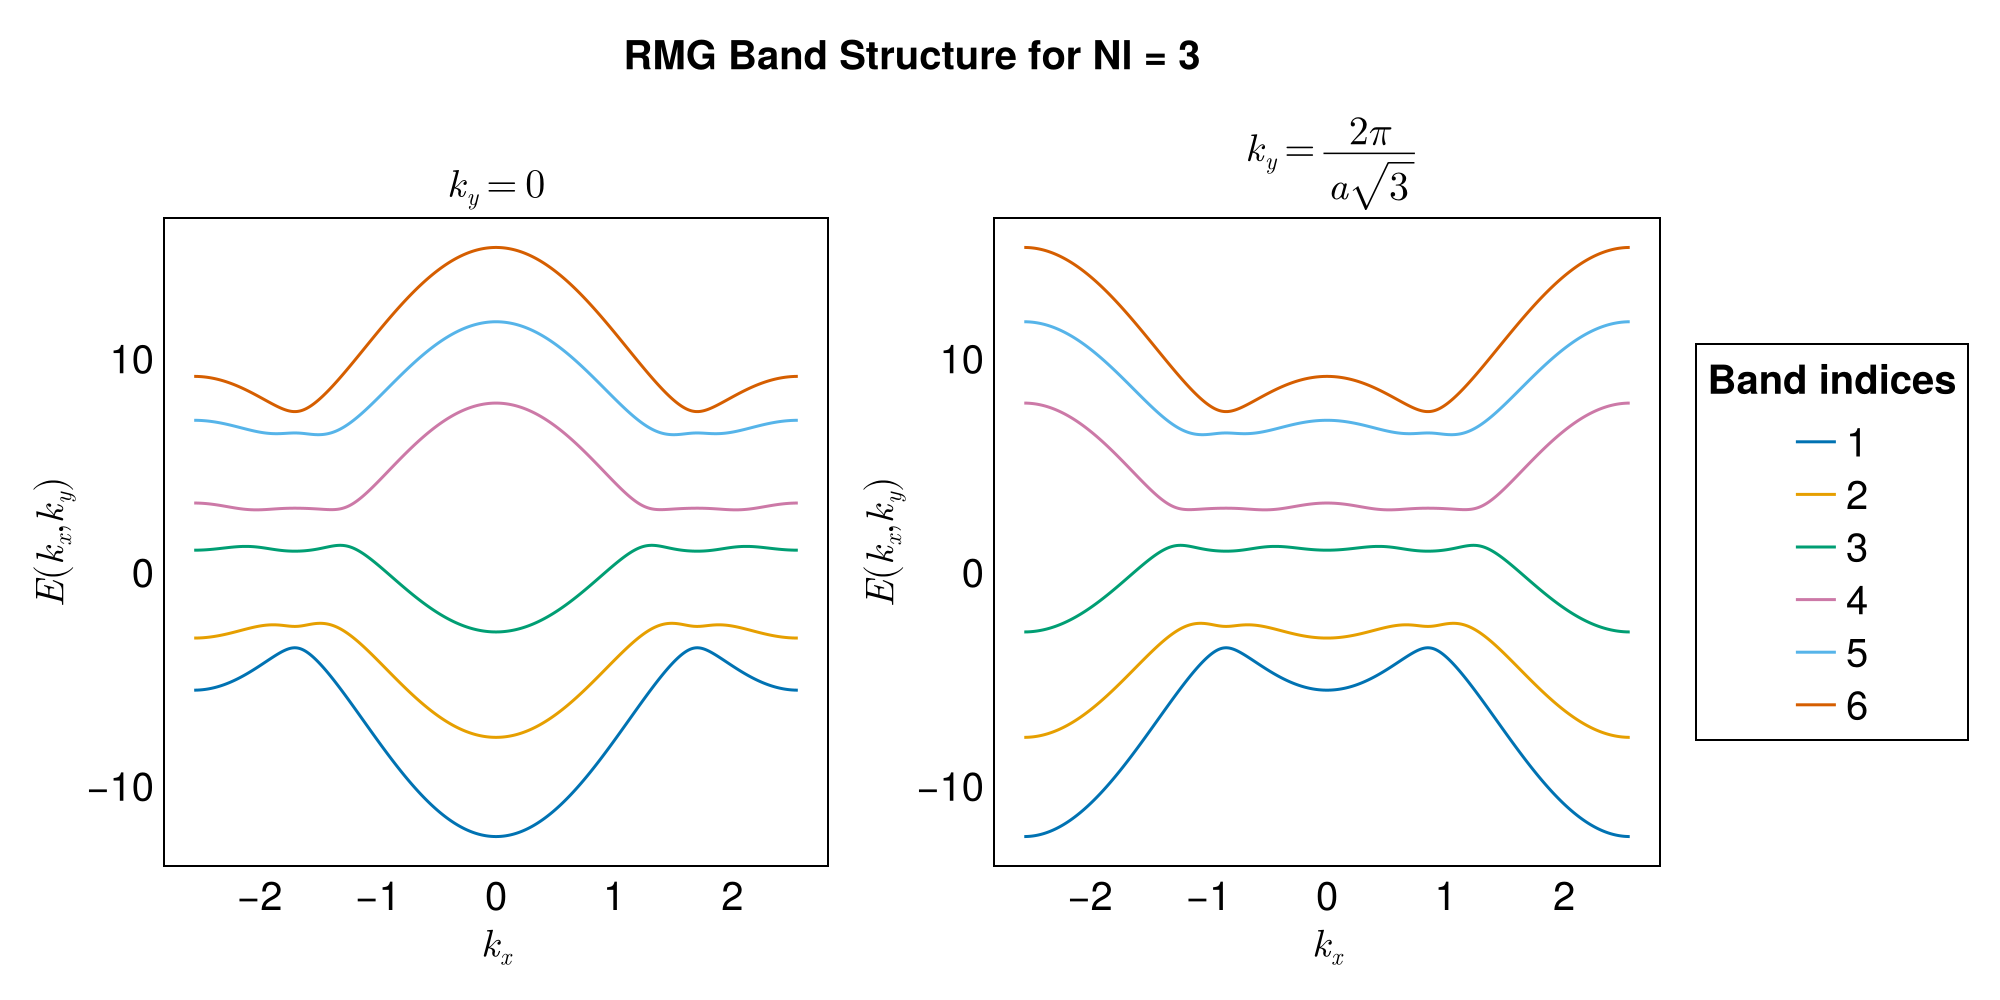

In [15]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax_k = Axis(P[1, 1], title = L"k_y = 0", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_k, label = false, ticklabels = false)
ax_kp = Axis(P[1, 2], title = L"k_y = \frac{2 \pi}{a \sqrt{3}}", xlabel = L"k_x", ylabel = L"E(k_x, k_y)")
hidedecorations!(ax_kp, label = false, ticklabels = false)
ax_major = Axis(P[:, :], title = string("RMG Band Structure for Nl = ", string(Nl)), titlegap = 70)
hidedecorations!(ax_major, label = false)
hidespines!(ax_major)

# plot bands
for i in 1:2*Nl
    lines!(ax_k, k_range, K_eigenvals[:, i], label = string(i))
    lines!(ax_kp, k_range, Kp_eigenvals[:, i], label = string(i))
end

# create and configure legend
P[1, 3] = Legend(P, ax_k, "Band indices", framevisible = true)
P

<font size="12">RMG Berry Curvature</font>

In [16]:
# pd is point-density
pd = 100
# lims for 1 unit cell
uc_xlim = 4*pi/(3*a)
uc_ylim = sqrt(3) / 2
# dimension of unit cell patchwork (n_cell x n_cell)
n_cell = 5
# dimensions of the enlarged k-space cell
xlim = n_cell * uc_xlim
ylim = n_cell * uc_ylim
# area of plaquette
area = (xlim / pd) * (ylim / pd)

0.0036865840736467832

There are a few important notes to make here. 
- We discretize a single unit cell into a parallelogram of ${pd}^2$ points in k-space.
- To observe interesting features of Berry curvature near Dirac points, we must compute the Berry curvature $> 1$ (${n_{cell}}^2$) unit cells. 
- Then we appropriately set the $x$ and $y$ limits ($xlim, ylim$) to ensure that the resulting patchwork of unit cells is still a parallelogram (this doesn't matter too much).

In [17]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a single unit cell of points in K-space
function gen_grid(xlim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(xlim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    return grid
end
# Shift a grid over
function shift_grid(grid, n, xshift, yshift)
    new_grid = copy(grid)
    for i in 1:n
        new_grid[:, i, 2] += yshift * ones(size(grid[:, i, 2]))
        new_grid[:, i, 1] += xshift * ones(size(grid[:, i, 1]))
    end
    return new_grid
end

shift_grid (generic function with 1 method)

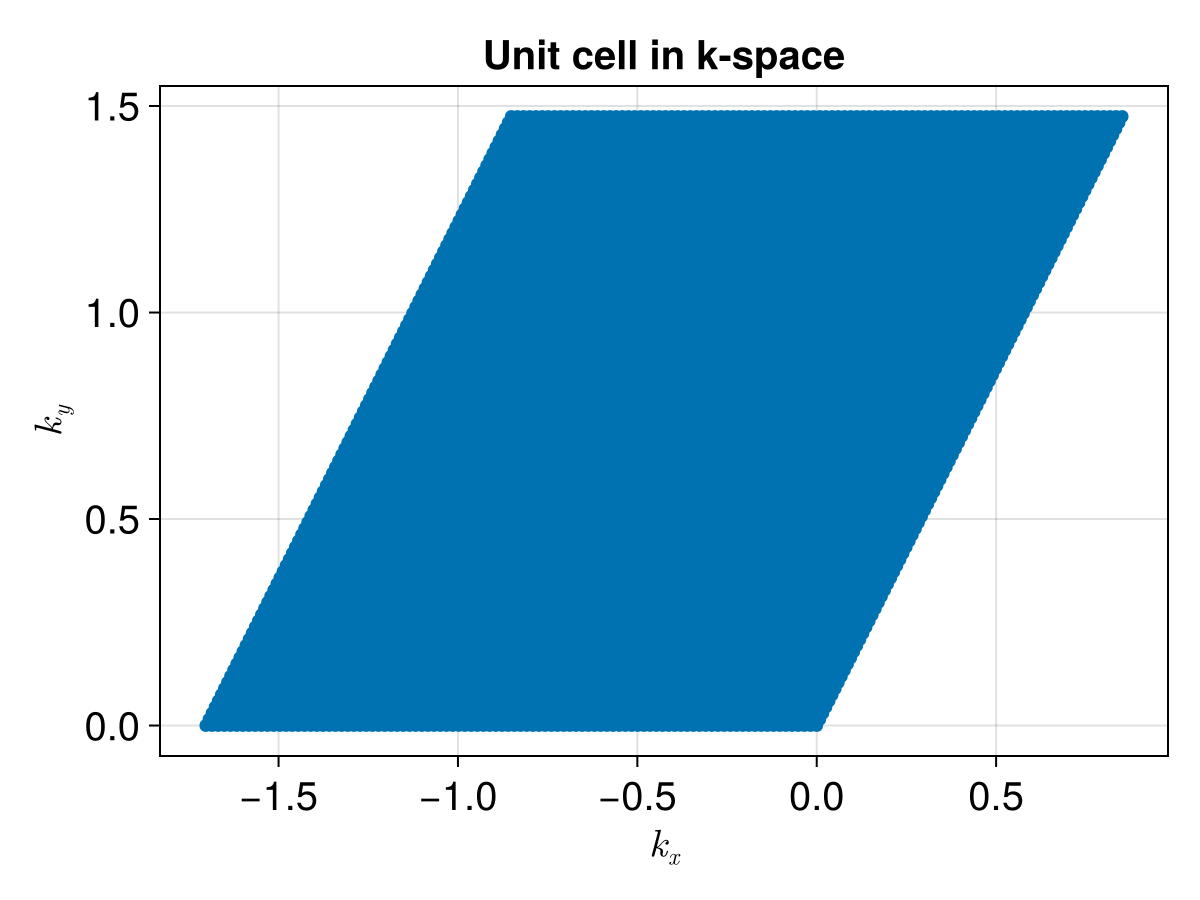

In [18]:
# Sample unit cell in k-space
uc_k_grid = gen_grid(uc_xlim, pd)
# uc_k_grid = shift_grid(uc_k_grid, pd, xlim, ylim)
uc_k_mesh = reshape(uc_k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "Unit cell in k-space", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, uc_k_mesh[:, 1], uc_k_mesh[:, 2])
P

This parallelogram is still a valid Brillouin zone because it is formed by connecting the centers of $4$ hexagons in k-space (which forms a Brillouin zone). The reason we use a parallelogram unit cell over a hexagonal unit cell is because there are Dirac points contained within the parallelogram, so it is easier to see unique Berry curvature behavior using this unit cell.

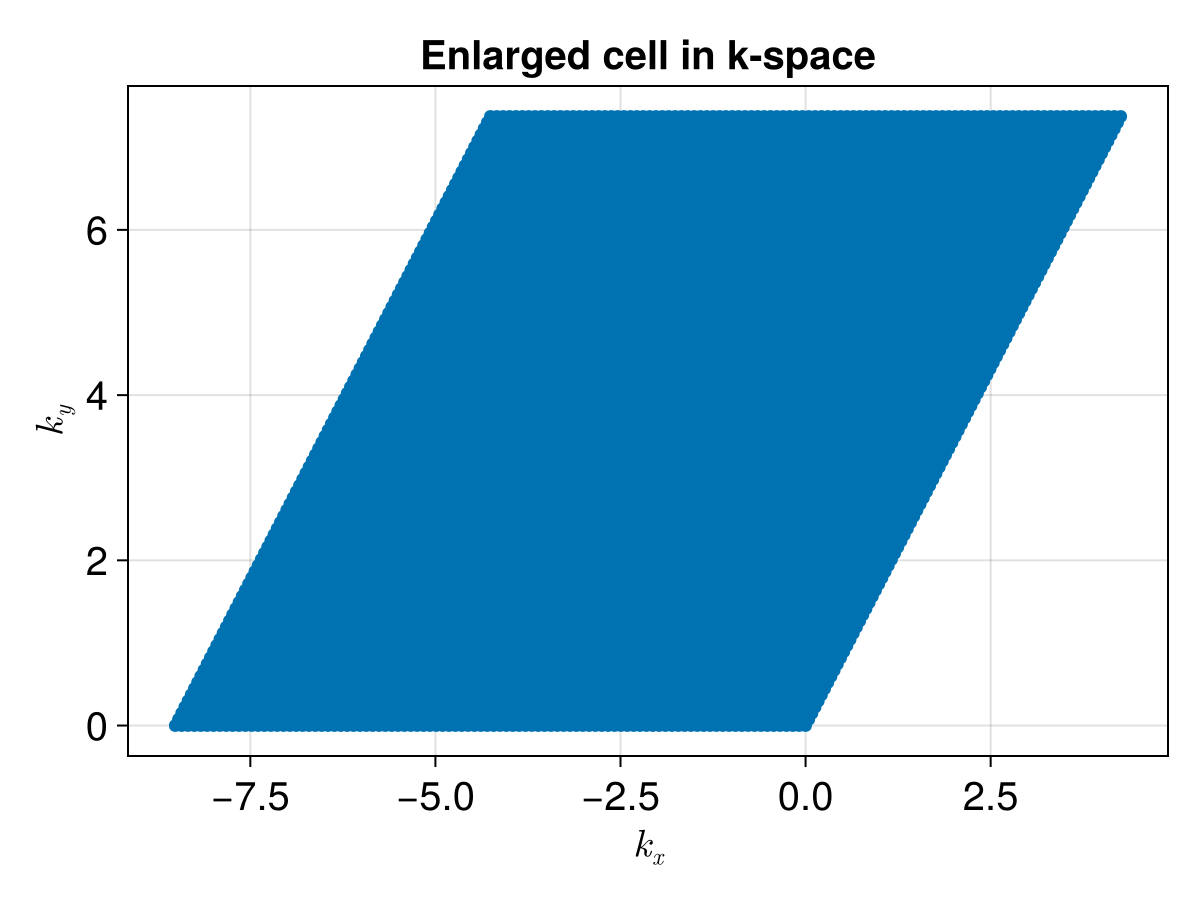

In [19]:
# Enlarged cell in k-space
k_grid = gen_grid(n_cell*uc_xlim, pd)
k_mesh = reshape(k_grid, (pd^2, 2))
P = Figure(fontsize = 20)
ax_major = Axis(P[:, :], title = "Enlarged cell in k-space", xlabel = L"$k_x$", ylabel = L"$k_y$")
scatter!(ax_major, k_mesh[:, 1], k_mesh[:, 2])
P

An important note regarding this discretization of k-space is that increasing $n_{cell}$ does not make the lattice finer. In contrast, it actually makes the lattice coarser since we now spread the same number of points across a larger region. So typically, when we increase $n_{cell}$ we will also have to increase $pd$ to ensure that the quality of the discrete Brillouin zone does not deteriorate too much.

Now we compute the Berry curvature according to the following method. This method provides a gauge-invariant computation of the Berry curvature for a discrete Brillouin zone. 
- Suppose $\psi_k^{l}$ is the wave-function for the $l^{\text{th}}$ band.
- Define $e^{i\theta_{12}}_l = \frac{\langle \psi_{k2}^l | \psi_{k1}^l \rangle}{| \langle \psi_{k2}^l | \psi_{k1}^l \rangle|}$
- Then we can compute the Berry flux through a plaquette with corners represented by points (1, 2, 3, 4) as 
$\Phi_{1234}^l = arg(e^{i\theta_{21}}_l e^{i\theta_{32}}_l e^{i\theta_{43}}_l e^{i\theta_{14}}_l)$
- Here we define the Berry curvature as $B_z^l (k) = A * \Phi_{1234}^l$ where $A$ is the area of the plaquette. In our actual computation we don't account for the area because it's just a proportionality factor.
- Then using this definition of the Berry curvature, we can compute the Chern number of a band as 
$C^l = \frac{1}{2 \pi} \int_{BZ} dk B^l_z (k)$ 
    - Here $\int_{BZ}$ is an integral over the Brillouin zone.

In [20]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec(l, kx, ky)
    ham = hRG(a, uD, t0, t1, t2, t3, t4, Nl, [kx, ky])
    vecs = eigvecs(Hermitian(ham))
    return vecs[:, l]
end

eigen_vec (generic function with 1 method)

In [21]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(l, x1, y1, x2, y2)
    ev1 = eigen_vec(l, x1, y1)
    ev2 = eigen_vec(l, x2, y2)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [22]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(l, x1, y1, x2, y2, x3, y3, x4, y4)
    big_theta = theta(l, x2, y2, x1, y1) *
        theta(l, x3, y3, x2, y2) * theta(l, x4, y4, x3, y3) * theta(l, x1, y1, x4, y4)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [23]:
# Berry curvature over all plaquettes
function berry_curvature(l, points, n)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(l, x1, y1, x2, y2, x3, y3, x4, y4)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [24]:
# Get berry curvature for all bands
@time begin
flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
uc_flux_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
kx_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
ky_avg_list = Array{Float64}(undef, 2*Nl, (pd - 1)^2)
for l in 1:2*Nl
    temp_flux, akx, aky = berry_curvature(l, k_grid, pd)
    uc_temp_flux, trash, trash = berry_curvature(l, uc_k_grid, pd)
    uc_flux_list[l, :] = uc_temp_flux
    flux_list[l, :] = temp_flux / area
    kx_avg_list[l, :] = akx
    ky_avg_list[l, :] = aky
end
end

  8.485288 seconds (42.43 M allocations: 16.343 GiB, 8.78% gc time, 1.69% compilation time)


In [25]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2*Nl)
for l in 1:2*Nl
    chern_numbers[l] = sum(uc_flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [4.329088316436453e-16, 5.47762195140939e-16, -1.0601848938211722e-16, 1.4135798584282297e-16, 1.236882376124701e-16, -3.754821498949985e-16]


6-element Vector{Float64}:
  4.329088316436453e-16
  5.47762195140939e-16
 -1.0601848938211722e-16
  1.4135798584282297e-16
  1.236882376124701e-16
 -3.754821498949985e-16

In [26]:
# Plot the Berry curvatures for each band over the enlarged cell
function plot_berry(fig, kx_list, ky_list, fluxes)
    for i in 1:2
        for j in 1:Nl
            index = (i - 1) * Nl + j
            t_string = "l = "*string(index)
            ax = Axis(fig[j, i], title = t_string)
            hidedecorations!(ax)
            tricontourf!(ax, kx_list[index, :], ky_list[index, :], fluxes[index, :], colormap = :Spectral)
        end
    end
    X, ax, tr = tricontourf(kx_list[1, :], ky_list[1, :], fluxes[1, :], colormap = :Spectral)
    cb = Colorbar(fig[1:Nl, 3], tr)
    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
end

plot_berry (generic function with 1 method)

 12.897394 seconds (20.88 M allocations: 1.261 GiB, 2.60% gc time, 30.62% compilation time)


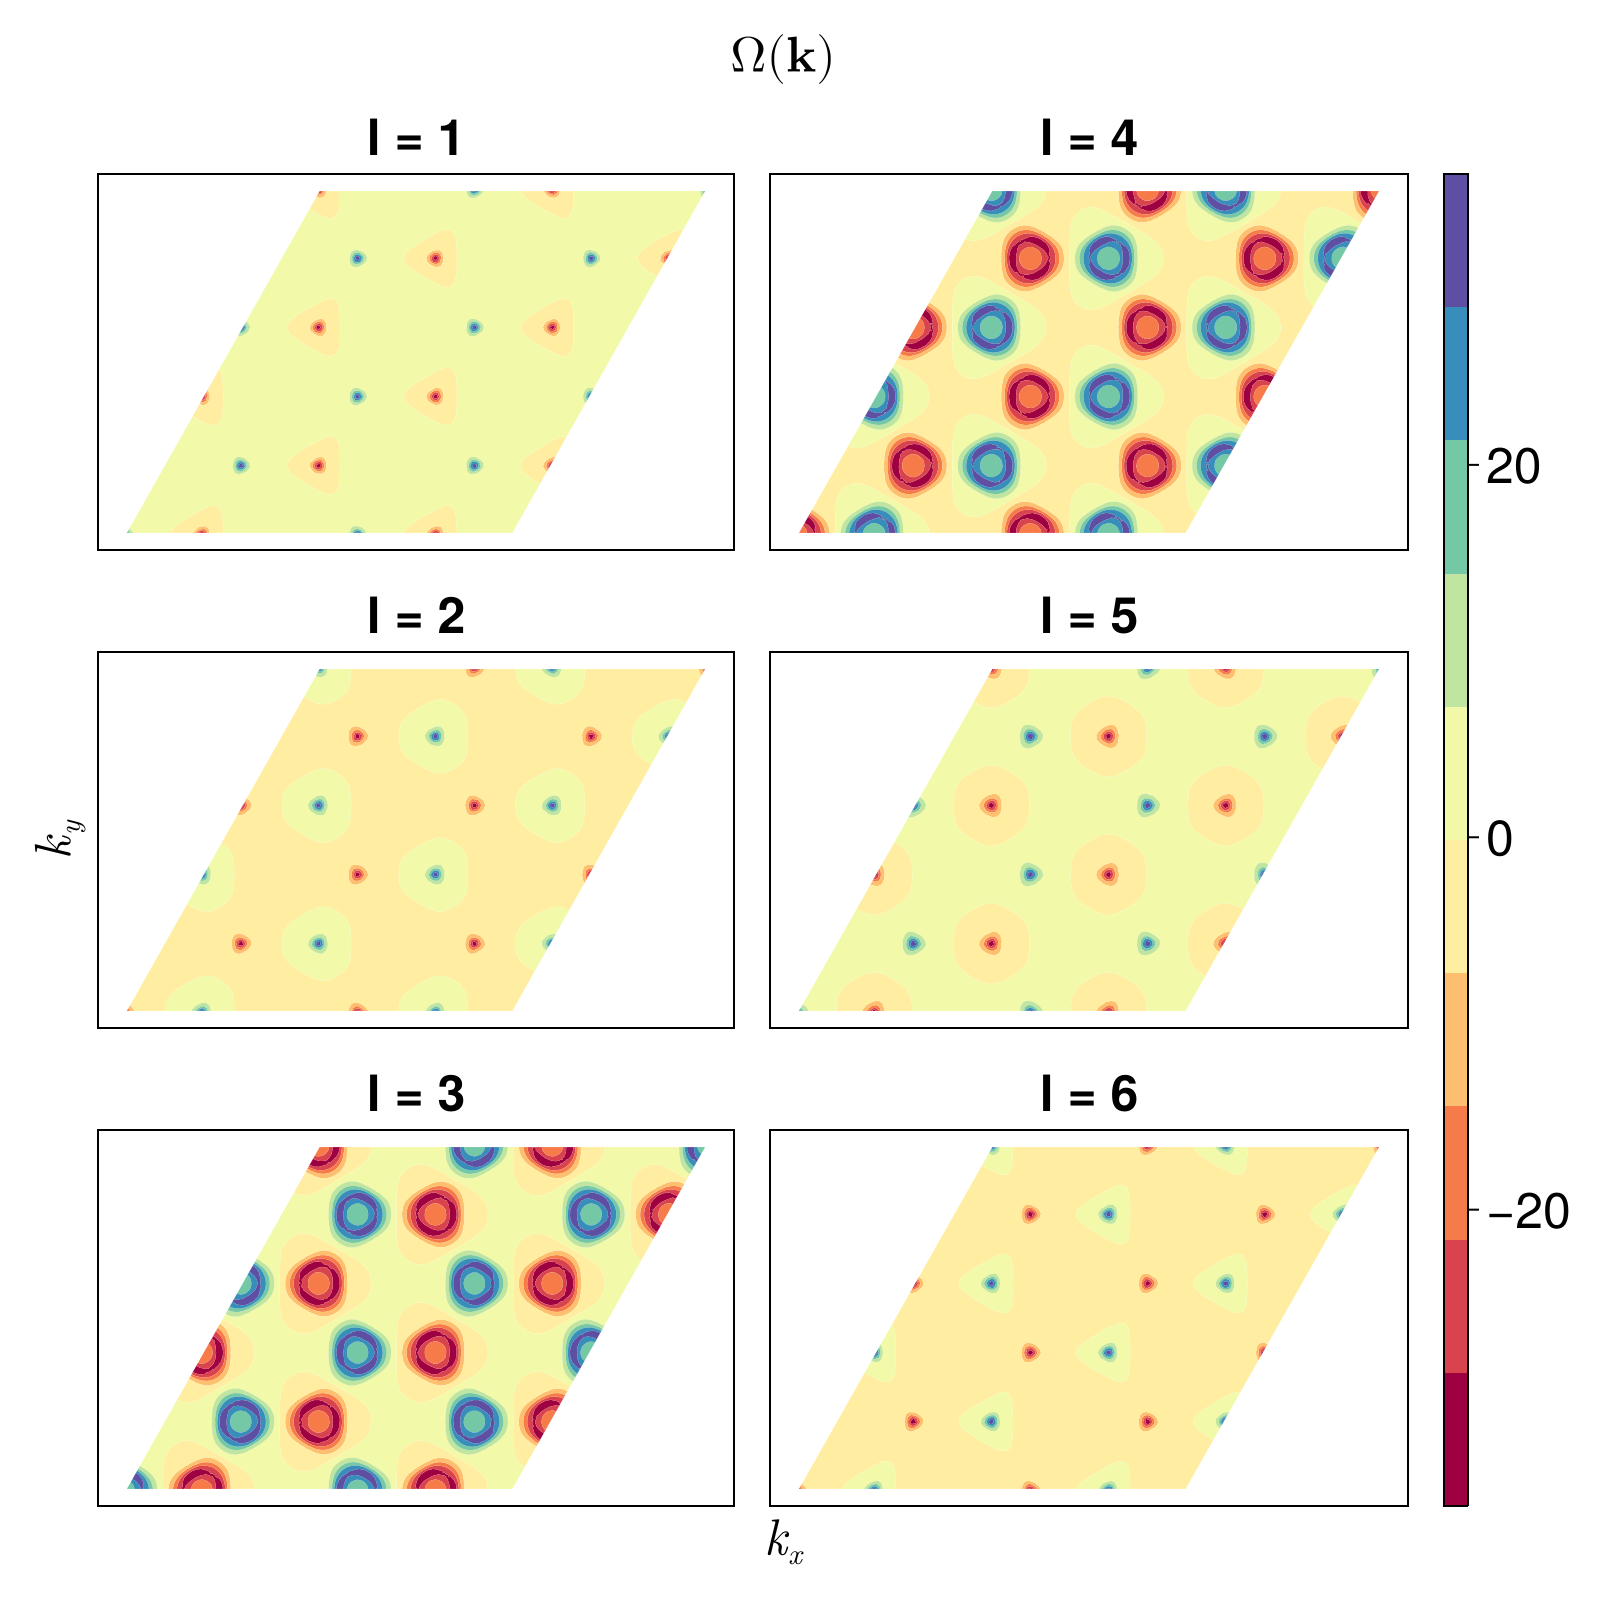

In [27]:
@time begin
berry_fig = Figure(size=(800, 800), fontsize=25)
plot_berry(berry_fig, kx_avg_list, ky_avg_list, flux_list)
end

In [28]:
# This is just part of an idea I had to potentially speed up computation time

# xvl = [uc_k_grid[2, 1, 1], uc_k_grid[2 - 1, 1, 1], uc_k_grid[2, 2, 1], uc_k_grid[2 - 1, 2, 1]]
# xvr = [uc_k_grid[end, 1, 1], uc_k_grid[end - 1, 1, 1], uc_k_grid[end, 2, 1], uc_k_grid[end - 1, 2, 1]]
# xshift = mean(xvr - xvl)
# yvl = [uc_k_grid[2, 1, 2], uc_k_grid[2 - 1, 1, 2], uc_k_grid[2, 2, 2], uc_k_grid[2 - 1, 2, 2]]
# yvr = [uc_k_grid[2, end - 1, 2], uc_k_grid[1, end - 1, 2], uc_k_grid[2, end, 2], uc_k_grid[1, end, 2]]
# yshift = mean(yvr - yvl)
# function uc_mesh(akx, aky, xs, ys, num_cells, n, Nl)
#     kx_list = Array{Float64}(undef, num_cells, num_cells, 2*Nl, (n - 1)^2)
#     ky_list = Array{Float64}(undef, num_cells, num_cells, 2*Nl, (n - 1)^2)
#     for y in 1:num_cells
#         shift_y = y * ys
#         for x in 1:num_cells
#             shift_x = x * xs + y * (xs / 2)
#             kx_list[y, x, :, :] = akx + shift_x * ones(size(akx))
#             ky_list[y, x, :, :] = aky + shift_y * ones(size(aky))
#         end
#     end
#     return kx_list, ky_list
# end
# akx_list, aky_list = uc_mesh(kx_avg_list, ky_avg_list, xshift, yshift, n_cell, pd, Nl)
# akx_list = reshape(akx_list, (n_cell^2, 2 * Nl, (pd - 1)^2))
# aky_list = reshape(aky_list, (n_cell^2, 2 * Nl, (pd - 1)^2))